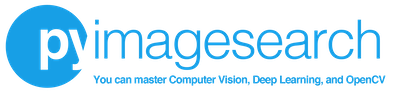

# Real-time object detection with deep learning and OpenCV
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Real-time object detection with deep learning and OpenCV](https://www.pyimagesearch.com/2017/09/18/real-time-object-detection-with-deep-learning-and-opencv/) blog post published on 2017-09-18.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at http://pyimg.co/plus/ today.*

### Install the necessary packages

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/real-time-object-detection/real-time-object-detection.zip
!unzip -qq real-time-object-detection.zip

--2023-05-17 14:51:51--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/real-time-object-detection/real-time-object-detection.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 3.5.84.214, 52.218.217.233, 52.92.129.90, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|3.5.84.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21376463 (20M) [binary/octet-stream]
Saving to: ‘real-time-object-detection.zip’

real-time-object-de 100%[===================>]  20.39M  23.0MB/s    in 0.9s    

2023-05-17 14:51:52 (23.0 MB/s) - ‘real-time-object-detection.zip’ saved [21376463/21376463]

/content/real-time-object-detection


In [1]:
%cd real-time-object-detection

C:\Users\msagardi\git_repositories\detection_segmentation_pytorch\04_basic_object_detection_pyimagesearch\04_pretrained_opencv_caffe_realtime\real-time-object-detection


## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
from matplotlib import pyplot as plt
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

### Object detection in video with deep learning and OpenCV

In [5]:
# first, let's get a video on which we can run our face mask detector 
!wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/janie.mp4

--2023-05-17 17:10:07--  https://colab-notebook-videos.s3-us-west-2.amazonaws.com/janie.mp4
Resolving colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)... 3.5.81.156, 52.92.130.18, 52.92.242.2, ...
Connecting to colab-notebook-videos.s3-us-west-2.amazonaws.com (colab-notebook-videos.s3-us-west-2.amazonaws.com)|3.5.81.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3413203 (3.3M) [video/mp4]
Saving to: 'janie.mp4.1'

     0K .......... .......... .......... .......... ..........  1%  122K 27s
    50K .......... .......... .......... .......... ..........  3% 50.3M 13s
   100K .......... .......... .......... .......... ..........  4%  241K 13s
   150K .......... .......... .......... .......... ..........  6% 39.5M 10s
   200K .......... .......... .......... .......... ..........  7% 48.2M 8s
   250K .......... .......... .......... .......... ..........  9%  106M 6s
   300K .......... .......... ..........

In [6]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--prototxt", required=True,
#	help="path to Caffe 'deploy' prototxt file")
#ap.add_argument("-m", "--model", required=True,
#	help="path to Caffe pre-trained model")
#ap.add_argument("-c", "--confidence", type=float, default=0.2,
#	help="minimum probability to filter weak detections")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input" : "janie.mp4",
    "output" : "output.avi",
    "prototxt": "MobileNetSSD_deploy.prototxt.txt",
    "model": "MobileNetSSD_deploy.caffemodel",
    "confidence" : 0.5
}

In [7]:
# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
    "sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNetFromCaffe(args["prototxt"], args["model"])

[INFO] loading model...


In [8]:
# grab a reference to the video file, initialize pointer to output
# video file, and initialize the FPS counter
print("[INFO] opening video file...")
vs = cv2.VideoCapture(args["input"])
writer = None
fps = FPS().start()

[INFO] opening video file...


In [9]:
# loop over the frames from the video stream
while True:
    # grab the next frame
    frame = vs.read()[1]

    # if we did not grab a frame then we have reached the end of the
    # video
    if frame is None:
        break

    # resize the frame to have a maximum width of 400 pixels
    frame = imutils.resize(frame, width=400)

    # grab the frame dimensions and convert it to a blob
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 0.007843, (300, 300), 127.5)

    # pass the blob through the network and obtain the detections and
    # predictions
    net.setInput(blob)
    detections = net.forward()

    # loop over the detections
    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > args["confidence"]:
            # extract the index of the class label from the
            # `detections`, then compute the (x, y)-coordinates of
            # the bounding box for the object
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # draw the prediction on the frame
            label = "{}: {:.2f}%".format(CLASSES[idx],
                confidence * 100)
            cv2.rectangle(frame, (startX, startY), (endX, endY),
                COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(frame, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

    # update the FPS counter
    fps.update()

    # if the video writer is None *AND* we are supposed to write
    # the output video to disk initialize the writer
    if writer is None and args["output"] is not None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(args["output"], fourcc, 20,
            (frame.shape[1], frame.shape[0]), True)

    # if the writer is not None, write the frame with recognized
    # faces to disk
    if writer is not None:
        writer.write(frame)
  
# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
    writer.release()

[INFO] elapsed time: 11.41
[INFO] approx. FPS: 11.05


In [10]:
#
!ffmpeg -i output.avi output.mp4

'ffmpeg' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Real-time object detection with deep learning and OpenCV*](https://www.pyimagesearch.com/2017/09/18/real-time-object-detection-with-deep-learning-and-opencv/)  published on 2017-09-18.


# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```